# 1. Data Visualization

In [28]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn as sb
sns.set_style('darkgrid')

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [30]:
data = pd.read_csv('airline_data.csv')

In [31]:
data

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


Text(0, 0.5, 'Frequency')

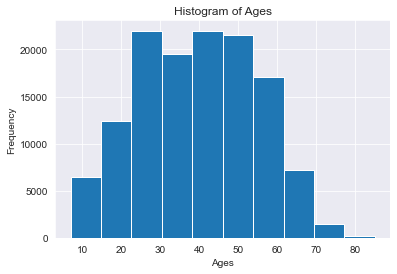

In [32]:
#Age Distribution
data['Age'].hist(bins=10)
plt.title("Histogram of Ages")
plt.xlabel('Ages')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

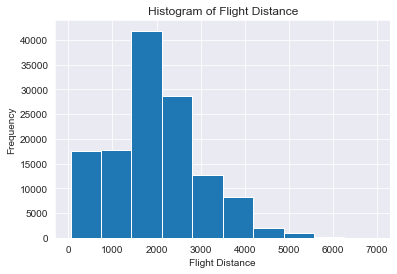

In [33]:
#Flight Distance
data['Flight Distance'].hist(bins=10)
plt.title("Histogram of Flight Distance")
plt.xlabel('Flight Distance')
plt.ylabel('Frequency')

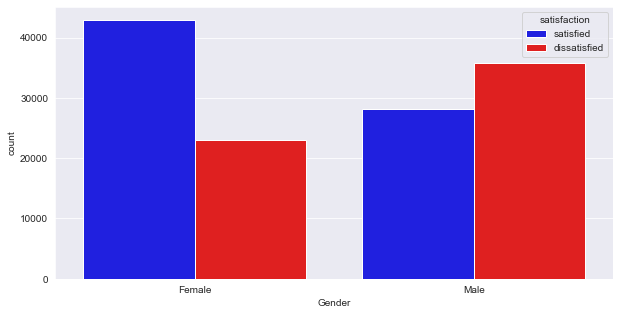

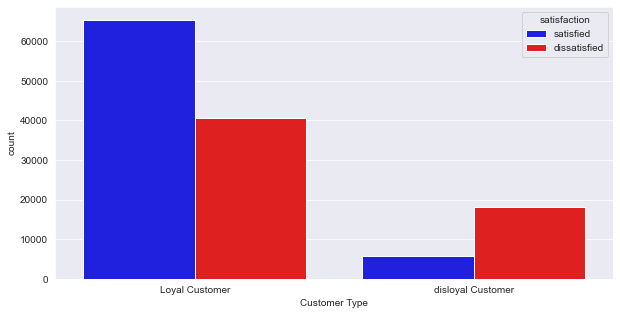

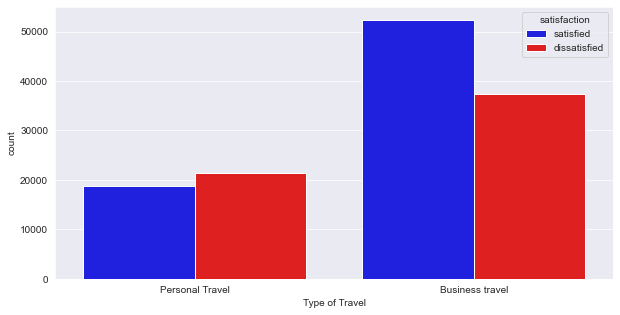

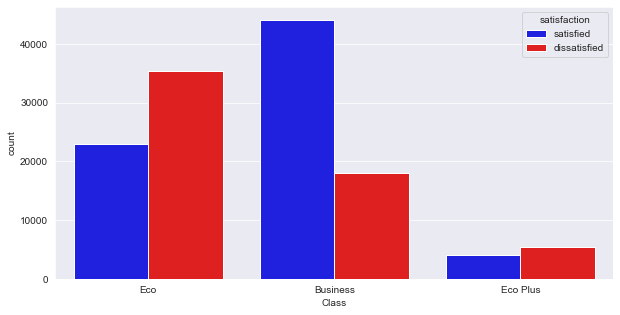

In [38]:
#Analyze object data
for col in data.select_dtypes(include = 'object'):
    if col != 'satisfaction':
        plt.figure(figsize = (10, 5))
        sb.countplot(x = col, data = data, hue = 'satisfaction', palette = ['blue', 'red'])
        plt.show()

# 2. Data Preprocessing

In [ ]:
def preprocess(df):
    df = df.copy() #we want to create a copy of the dataframe
    df['Arrival Delay in Minutes'] =df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())
    
    #To distinguish binary variables, we are going to use binary classification
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['Customer Type'] = df['Customer Type'].replace({'disloyal Customer': 0, 'Loyal Customer': 1})
    df['Type of Travel'] = df['Type of Travel'].replace({'Personal Travel': 0, 'Business travel': 1})
    ##################################################################
    
    #One hot coding
    flight_class = pd.get_dummies(df['Class'],prefix='Flight')
    df = pd.concat([df,flight_class],axis=1)
    df = df.drop('Class',axis=1)
    return df


In [ ]:
def classify_objects(X):
    return {col: len(X[col].unique()) for col in X.select_dtypes('object').columns} ,{col: list(X[col].unique()) for col in X.select_dtypes('object').columns}

In [ ]:
class_len, class_list = classify_objects(data) #after preprocessing all the data, we are going to classify them into data classes
print('class_len:',class_len)
print('class_list:',class_list)

In [ ]:
X = preprocess(data)
X

# 3. Outliers Checking

In [ ]:
#Box Plotter Function
def boxplotter(non_binary_columns,df,title):
    plt.figure(figsize=(20,20))
    for idx, col in enumerate(non_binary_columns):
        plt.subplot(3,6,idx + 1)
        sns.boxplot(data=df[col],color='blue')
        plt.title(col)

    plt.suptitle(title,size=30)
    plt.show()

In [ ]:
drop_sat_df = X.drop('satisfaction', axis=1).copy()
#check if there are more than two types of classification data variables
non_binary_columns = [col for col in drop_sat_df.columns if len(drop_sat_df[col].unique()) > 2]
title = 'Boxplots With Outliers'
boxplotter(non_binary_columns,drop_sat_df,title)

In [ ]:
#IMPORTANT: High z-score means that the data is likely an outlier
pd.Series(scipy.stats.zscore(X['Departure Delay in Minutes']))

In [ ]:
def remove_outliers(df,columns,threshold):
    df = df.copy()
    columns = ['On-board service','Checkin service','Departure Delay in Minutes','Arrival Delay in Minutes']
    #Calculate the Lower and Upper Bound for the Z distribution given a threshold value
    lower_bound = scipy.stats.norm.ppf(q= 0.5*threshold,loc=0,scale=1)
    upper_bound = scipy.stats.norm.ppf(q= 1 - 0.5*threshold,loc=0,scale=1)
    
    #Calculate the z-scores of every example in the columns specified
    outlier_df = df.loc[:,columns].copy()
    zscores = scipy.stats.zscore(outlier_df,axis=0)
    zscores_df = pd.DataFrame(zscores) 
    
    #Boolean arrays deonting the outlier examples
    lower_outliers = (zscores < lower_bound)
    upper_outliers = (zscores >= upper_bound)
    lower_outliers_df = pd.DataFrame(lower_outliers)
    upper_outliers_df = pd.DataFrame(lower_outliers)
    
    #Indicies of all outliers
    outliers = df[pd.concat([lower_outliers,upper_outliers],axis=1).any(axis=1)].index
    
    #Drop the outliers
    df = df.drop(outliers, axis=0).reset_index(drop=True)
    print(len(outliers),'examples dropped')
    
    return df

In [ ]:
threshold = 0.05
specified_columns = ['On-board service','Checkin service','Departure Delay in Minutes','Arrival Delay in Minutes']
outlier_df = remove_outliers(X,specified_columns,threshold)

In [ ]:
outlier_df

In [ ]:
#Box plot without outliers
title = 'Boxplots Without Outliers'
boxplotter(non_binary_columns,outlier_df,title)

# 4. Machine Learning & Dataset Training

In [ ]:
def training(df,determine_outliers=True,outliers_threshold=0.05):
    df = df.copy()
    
    if determine_outliers == False:
        df = remove_outliers(df,
                             columns=['On-board service','Checkin service','Departure Delay in Minutes','Arrival Delay in Minutes','Online boarding'],
                             threshold=outliers_threshold)
    
    #Split the data into X and Y
    y = df['satisfaction']
    X = df.drop('satisfaction',axis=1)
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=True,random_state=1)
    
    #scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train),index=X_train.index,columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

### Outlier is NOT removed

In [ ]:
X_train1, X_test1, y_train1, y_test1 = training(X,determine_outliers=True)
model1 = LogisticRegression()
model1.fit(X_train1,y_train1)
model1_accuracy = ('Test Accuracy:{:.3f}%'.format(model1.score(X_test1,y_test1)*100))
model1_accuracy

### Outlier is removed

In [ ]:
X_train2, X_test2, y_train2, y_test2 = training(X,determine_outliers=False,outliers_threshold=0.12)
model2 = LogisticRegression()
model2.fit(X_train2,y_train2)
model2_accuracy = ('Test Accuracy:{:.3f}%'.format(model2.score(X_test2,y_test2)*100))
model2_accuracy